# Quora duplicate question identification

- Model https://www.kaggle.com/c/quora-question-pairs/discussion/33631

In [0]:
%%capture
%%bash
pip install -q tf-nightly
pip install -q comet_ml

In [0]:
from comet_ml import Experiment
import re
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Add, Bidirectional, Concatenate, Dropout, Input, Dense, Embedding, LSTM, Reshape
from tensorflow.keras.utils import plot_model

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

from sklearn.model_selection import train_test_split

In [4]:
tf.__version__

'2.2.0-dev20200218'

In [5]:
experiment = Experiment(api_key=COMET_API_KEY, project_name="quora-duplicate-questions", workspace="dzlab")

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/dzlab/quora-duplicate-questions/7d9c812f6b5b4aee87eb1fcf68f1970d



In [0]:
class config: pass
config.bs = 64
config.seed = 31
config.max_tokens = 10000
config.max_length = 200
config.embed_size = 100
config.dropout = 0.3

## Data

In [9]:
%%bash
mkdir /root/.kaggle/
mv kaggle.json /root/.kaggle/
chmod 600 /root/.kaggle/kaggle.json
kaggle competitions download -c quora-question-pairs
unzip -q train.csv.zip
unzip -q test.csv.zip




test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


mkdir: cannot create directory ‘/root/.kaggle/’: File exists
100%|##########| 173M/173M [00:01<00:00, 105MB/s] 
100%|##########| 4.95M/4.95M [00:00<00:00, 40.3MB/s]
100%|##########| 21.2M/21.2M [00:00<00:00, 53.5MB/s]


In [0]:
train_df, valid_df = train_test_split(pd.read_csv('./train.csv'), train_size=0.8, random_state=config.seed)
#test_df = pd.read_csv('./test.csv')

### EDA

In [9]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
72311,72311,41051,124277,"If you had $20k to invest in Apple, Google, Fa...",Which is the best Indian stock to buy for long...,0
382288,382288,514125,514126,What is the Illuminati and what is its function?,What was the Illuminati and how did they origi...,1
163852,163852,254755,223618,Which are the top five pilot training institut...,What are the best commercial pilot training sc...,0
202668,202668,305032,56705,How can you wake up earlier?,How do I wake up earlier?,1
13621,13621,26140,26141,How do you spy on Facebook without a target ph...,What do you do to spy on Facebook messages wit...,1


In [10]:
valid_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
87461,87461,147305,53562,Why is Hillary Clinton blamed for the Benghazi...,Why is Hillary Clinton blamed for Benghazi att...,1
296253,296253,418431,418432,Are pudding eaten cold?,Is yogurt eaten or drunk?,0
255991,255991,33632,2855,How can I be indifferent to what people think ...,Should I ever care what people think of me?,1
95728,95728,159582,159583,How many feet are in a mile and a half?,How many feet there are in a mile?,0
55838,55838,98389,98390,Does long distance relationship work for teen?,Does long distance relationship work for the y...,1


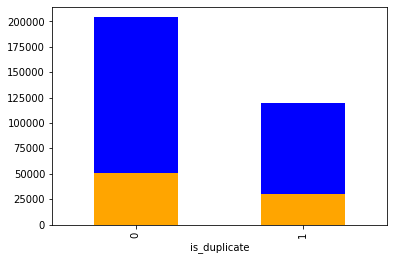

In [28]:
train_df.groupby("is_duplicate").count()['id'].plot.bar(color='blue')
valid_df.groupby("is_duplicate").count()['id'].plot.bar(color='orange')

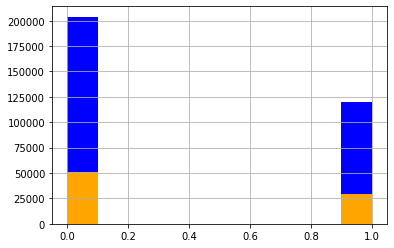

In [35]:
train_df['is_duplicate'].hist(color='blue')
valid_df['is_duplicate'].hist(color='orange')

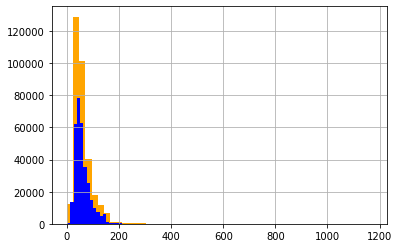

In [36]:
train_df['question2'].map(lambda q: len(str(q))).hist(bins=50, color='orange')
train_df['question1'].map(lambda q: len(str(q))).hist(bins=50, color='blue')

### Dataset
Create dataset for training

In [0]:
train_q1 = np.array(train_df['question1'].values, dtype=np.unicode)
train_q2 = np.array(train_df['question2'].values, dtype=np.unicode)
train_label = train_df['is_duplicate'].values

In [0]:
valid_q1 = np.array(valid_df['question1'].values, dtype=np.unicode)
valid_q2 = np.array(valid_df['question2'].values, dtype=np.unicode)
valid_label = valid_df['is_duplicate'].values

In [0]:
train_ds = tf.data.Dataset.from_tensor_slices(((train_q1, train_q2), train_label)).batch(config.bs)
valid_ds = tf.data.Dataset.from_tensor_slices(((valid_q1, valid_q2), valid_label)).batch(config.bs)

## TF-IDF
### TextVectorization
Initialize a TextVectorization layer and build a vocabulary.



In [0]:
tfidf_q1 = TextVectorization(
  standardize = 'lower_and_strip_punctuation',
  split       = 'whitespace',
  max_tokens  = config.max_tokens,
  output_mode ='tf-idf',
  pad_to_max_tokens=False)
# adapt on entire dataset to not miss any token
tfidf_q1.adapt(np.concatenate((train_q1, valid_q1)))

In [0]:
sample_q1 = np.expand_dims(train_q1[:2], axis=-1)
pd.DataFrame(tfidf_q1(sample_q1).numpy())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,9960,9961,9962,9963,9964,9965,9966,9967,9968,9969,9970,9971,9972,9973,9974,9975,9976,9977,9978,9979,9980,9981,9982,9983,9984,9985,9986,9987,9988,9989,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,12.90989,1.292918,0.000000,0.000000,0.0,0.0,0.0,3.451042,1.708668,0.0,0.0,0.0,2.029923,0.0,0.0,2.4436,2.387749,2.557253,0.0,0.0,0.0,0.0,2.978023,3.022346,3.029408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.00000,1.292918,2.589466,2.858114,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,2.029923,0.0,0.0,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
tfidf_q2 = TextVectorization(
  standardize = 'lower_and_strip_punctuation',
  split       = 'whitespace',
  max_tokens  = config.max_tokens,
  output_mode ='tf-idf',
  pad_to_max_tokens=False)
# adapt on entire dataset to not miss any token
tfidf_q2.adapt(np.concatenate((train_q2, valid_q2)))

In [0]:
sample_q2 = np.expand_dims(train_q2[:2], axis=-1)
pd.DataFrame(tfidf_q2(sample_q2).numpy())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,9960,9961,9962,9963,9964,9965,9966,9967,9968,9969,9970,9971,9972,9973,9974,9975,9976,9977,9978,9979,9980,9981,9982,9983,9984,9985,9986,9987,9988,9989,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.0,1.295748,0.000000,1.422317,0.0,0.00000,0.0,1.67688,0.0,0.0,0.0,0.0,0.0000,0.0,2.22012,0.0,0.0,0.0,2.503583,0.0,0.0,0.0,0.0,0.0,0.0,2.982763,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.295748,1.304782,0.000000,0.0,1.55005,0.0,0.00000,0.0,0.0,0.0,0.0,2.0447,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's check the vocab created by both vectorizers

In [0]:
sentence = np.array(['hillary'])
tokens1 = tfidf_q1._index_lookup_layer(sentence)
tokens2 = tfidf_q2._index_lookup_layer(sentence)
tokens1.numpy(), tokens2.numpy()

(array([208]), array([213]))

### Model

In [0]:
q1_input = Input(shape=(1,), dtype=tf.string)
q2_input = Input(shape=(1,), dtype=tf.string)

tfidf1 = tfidf_q1(q1_input)
tfidf2 = tfidf_q2(q2_input)
output = Add()([tfidf1, tfidf2])
output = Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid")(output)

model = Model(inputs=[q1_input, q2_input], outputs=output)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

In [0]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 10000)        0           input_7[0][0]                    
__________________________________________________________________________________________________
text_vectorization_1 (TextVecto (None, 10000)        0           input_8[0][0]                    
____________________________________________________________________________________________

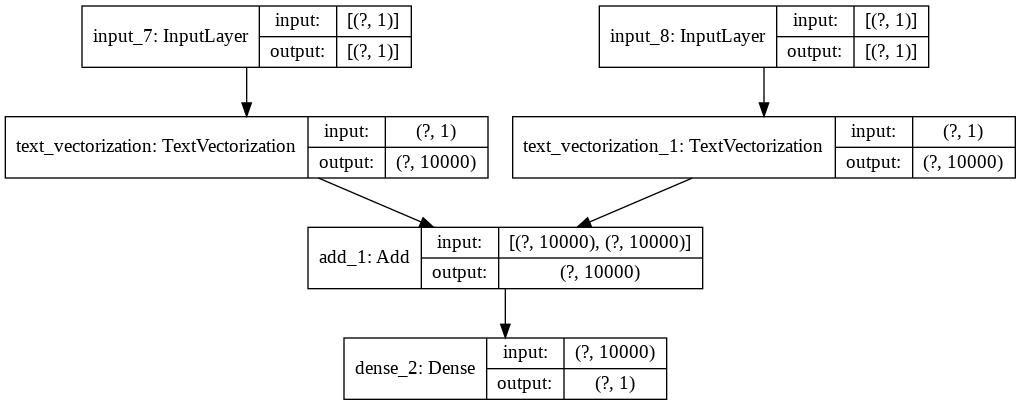

In [0]:
plot_model(model, to_file='quora-duplicate-questions.png', show_shapes=True)

In [0]:
experiment.log_image('quora-duplicate-questions.png')

{'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=10cb4edd116c4c6e851eaeffa8b0ab9a&experimentKey=b24967c083b64df0a5f9387b9773f179',
 'imageId': '10cb4edd116c4c6e851eaeffa8b0ab9a',
 'web': 'https://www.comet.ml/api/image/download?imageId=10cb4edd116c4c6e851eaeffa8b0ab9a&experimentKey=b24967c083b64df0a5f9387b9773f179'}

In [0]:
model.fit(train_ds, validation_data=valid_ds, epochs=10)

Train for 5054 steps, validate for 1264 steps
Epoch 1/10
5054/5054 [==============================] - 40s 8ms/step - loss: 0.5417 - accuracy: 0.7314 - val_loss: 0.5363 - val_accuracy: 0.7350
Epoch 2/10
5054/5054 [==============================] - 39s 8ms/step - loss: 0.5324 - accuracy: 0.7387 - val_loss: 0.5421 - val_accuracy: 0.7332
Epoch 3/10
5054/5054 [==============================] - 39s 8ms/step - loss: 0.5326 - accuracy: 0.7387 - val_loss: 0.5449 - val_accuracy: 0.7324
Epoch 4/10
5054/5054 [==============================] - 39s 8ms/step - loss: 0.5328 - accuracy: 0.7386 - val_loss: 0.5463 - val_accuracy: 0.7318
Epoch 5/10
5054/5054 [==============================] - 39s 8ms/step - loss: 0.5330 - accuracy: 0.7384 - val_loss: 0.5472 - val_accuracy: 0.7315
Epoch 6/10
5054/5054 [==============================] - 39s 8ms/step - loss: 0.5331 - accuracy: 0.7384 - val_loss: 0.5478 - val_accuracy: 0.7313
Epoch 7/10
5054/5054 [==============================] - 39s 8ms/step - loss: 0.5332 

## LSTM

### TextVectorization

In [0]:
int_q1 = TextVectorization(
  standardize = 'lower_and_strip_punctuation',
  split       = 'whitespace',
  max_tokens  = config.max_tokens,
  output_sequence_length = config.max_length,
  output_mode ='int',
  pad_to_max_tokens=True)
# adapt on entire dataset to not miss any token
int_q1.adapt(np.concatenate((train_q1, valid_q1)))

In [44]:
sample_q1 = np.expand_dims(train_q1[:2], axis=-1)
pd.DataFrame(int_q1(sample_q1).numpy())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,25,16,175,4655,8,572,9,502,142,144,24,589,23,541,2425,2,18,1,2706,755,8,136,755,8863,13,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3,4,2,3285,13,3,4,121,662,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
int_q2 = TextVectorization(
  standardize = 'lower_and_strip_punctuation',
  split       = 'whitespace',
  max_tokens  = config.max_tokens,
  output_sequence_length = config.max_length,
  output_mode ='int',
  pad_to_max_tokens=True)
# adapt on entire dataset to not miss any token
int_q2.adapt(np.concatenate((train_q2, valid_q2)))

In [43]:
sample_q2 = np.expand_dims(train_q2[:2], axis=-1)
pd.DataFrame(int_q2(sample_q2).numpy())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,26,4,2,19,86,546,8,119,15,145,67,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3,61,2,3336,13,6,57,66,3204,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [51]:
vars(int_q1._index_lookup_layer)

{'_activity_regularizer': None,
 '_autocast': True,
 '_build_input_shape': TensorShape([2, None]),
 '_callable_losses': [],
 '_combiner': <_IndexLookupCombiner>,
 '_dtype_defaulted_to_floatx': False,
 '_dtype_policy': <Policy "string", loss_scale=None>,
 '_dynamic': False,
 '_expects_mask_arg': False,
 '_expects_training_arg': False,
 '_inbound_nodes': [],
 '_initial_weights': None,
 '_input_spec': None,
 '_inverse_table': None,
 '_layers': [OrderedDict()],
 '_losses': [],
 '_max_elements': 9999,
 '_metrics': [],
 '_name': 'index_lookup_3',
 '_non_trainable_weights': [<tensorflow.python.keras.engine.base_layer_utils.TrackableWeightHandler at 0x7fc3f39884a8>],
 '_obj_reference_counts_dict': ObjectIdentityDictionary({<_ObjectIdentityWrapper wrapping 10000>: 1, <_ObjectIdentityWrapper wrapping 1>: 2, <_ObjectIdentityWrapper wrapping True>: 2, <_ObjectIdentityWrapper wrapping False>: 1, <_ObjectIdentityWrapper wrapping 2>: 1, <_ObjectIdentityWrapper wrapping 9999>: 1, <_ObjectIdentityWrapp

Let's check the vocab created by both vectorizers

In [45]:
sentence = np.array(['hillary'])
tokens1 = int_q1._index_lookup_layer(sentence)
tokens2 = int_q2._index_lookup_layer(sentence)
tokens1.numpy(), tokens2.numpy()

(array([209]), array([214]))

> A PAD token (encoded as 0) is added to the vocabulary, this is why the word `hilary` is encoded differently here.

### Model

In [0]:
input1 = Input(shape=(1,), dtype=tf.string)
input2 = Input(shape=(1,), dtype=tf.string)

int1 = int_q1(input1)
int2 = int_q2(input2)

# we must count for the PAD token, this is why +1
embed1 = Embedding(config.max_tokens + 1, config.embed_size, embeddings_initializer="glorot_uniform")(int1)
embed2 = Embedding(config.max_tokens + 1, config.embed_size, embeddings_initializer="glorot_uniform")(int2)

drop1 = Dropout(config.dropout)(embed1)
drop2 = Dropout(config.dropout)(embed2)

lstm1 = Bidirectional(LSTM(config.embed_size))(drop1)
lstm2 = Bidirectional(LSTM(config.embed_size))(drop2)

output = Concatenate()([lstm1, lstm2])
output = Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid")(output)

model = Model(inputs=[input1, input2], outputs=output)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

In [88]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
text_vectorization_3 (TextVecto (None, 200)          0           input_17[0][0]                   
__________________________________________________________________________________________________
text_vectorization_4 (TextVecto (None, 200)          0           input_18[0][0]                   
____________________________________________________________________________________________

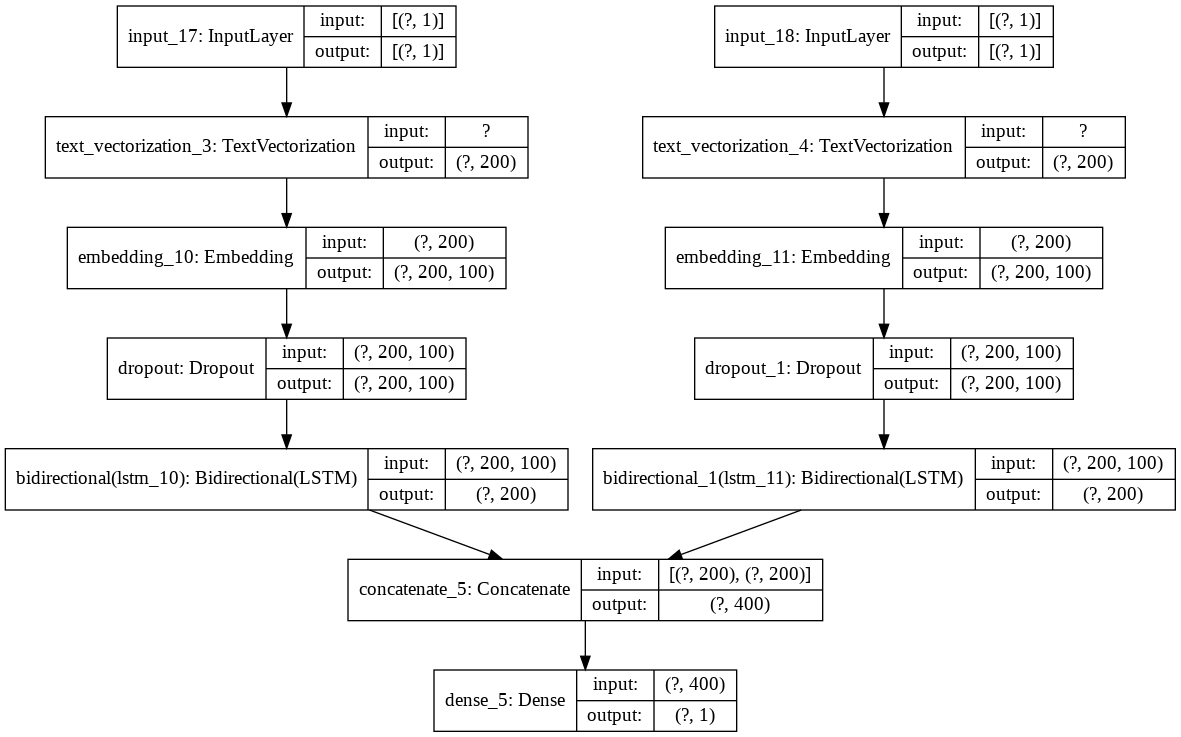

In [89]:
plot_model(model, to_file='quora-duplicate-questions-lstm.png', show_shapes=True)

In [90]:
experiment.log_image('quora-duplicate-questions-lstm.png')

{'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=ad949fe5da0f4ed3b3a7e3cfca079171&experimentKey=7d9c812f6b5b4aee87eb1fcf68f1970d',
 'imageId': 'ad949fe5da0f4ed3b3a7e3cfca079171',
 'web': 'https://www.comet.ml/api/image/download?imageId=ad949fe5da0f4ed3b3a7e3cfca079171&experimentKey=7d9c812f6b5b4aee87eb1fcf68f1970d'}

In [91]:
model.fit(train_ds, validation_data=valid_ds, epochs=10)

Train for 5054 steps, validate for 1264 steps
Epoch 1/10
5054/5054 [==============================] - 349s 69ms/step - loss: 0.5121 - accuracy: 0.7500 - val_loss: 0.4987 - val_accuracy: 0.7573
Epoch 2/10
5054/5054 [==============================] - 440s 87ms/step - loss: 0.4630 - accuracy: 0.7809 - val_loss: 0.4951 - val_accuracy: 0.7623
Epoch 3/10
5054/5054 [==============================] - 457s 90ms/step - loss: 0.4217 - accuracy: 0.8045 - val_loss: 0.5151 - val_accuracy: 0.7518
Epoch 4/10
5054/5054 [==============================] - 459s 91ms/step - loss: 0.3768 - accuracy: 0.8298 - val_loss: 0.5478 - val_accuracy: 0.7429
Epoch 5/10
5054/5054 [==============================] - 467s 92ms/step - loss: 0.3392 - accuracy: 0.8482 - val_loss: 0.5988 - val_accuracy: 0.7326
Epoch 6/10
5054/5054 [==============================] - 462s 91ms/step - loss: 0.3103 - accuracy: 0.8627 - val_loss: 0.6342 - val_accuracy: 0.7430
Epoch 7/10
5054/5054 [==============================] - 461s 91ms/step -